In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [0]:
tf.enable_eager_execution()

Weather-time series dataset from Max-Planck Institute for Biogeochemistry: features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. You will use only the data collected between 2009 and 2016 for Efficiency


In [0]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [0]:
df = pd.read_csv(csv_path)

In [0]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


For a single hour, you will have 6 observations.
A single day will contain 144 (=6x24) observations.

 If you want to predict the temperature 6 hours in the future, you can use 5 days of observations. Thus, you would create a window containing the last 720 (=5x144) observations to train the model. 

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

Parameter history_size is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. 



In [0]:
TRAIN_SPLIT = 300000

The first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [0]:
tf.random.set_random_seed(13)

Extract only the temperature from the dataset.

In [0]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf97a74a90>],
      dtype=object)

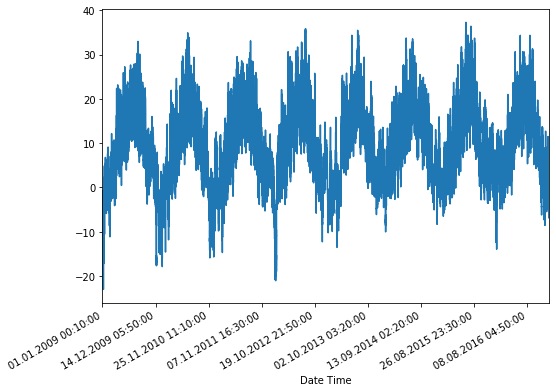

In [0]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

Normalize features before training a neural network.
Common way to do so is by subtracting the mean and dividing by the standard deviation of each feature. The mean and standard deviation should only be computed using the training data.

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step.

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [0]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


The information given to the network is given in blue, and it must predict the value at the red cross.

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

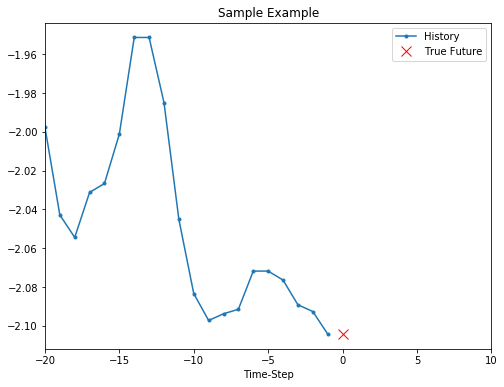

In [0]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

Baseline: Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

The goal of the trained model is to predict better than the baseline as it learns from the data.


In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

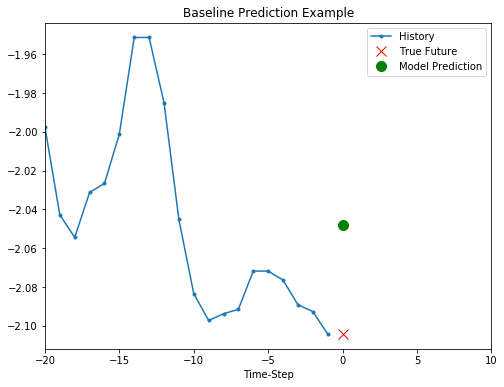

In [0]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Recurrent Neural Network: Well-suited Neural Network for Time-Series Data. you will use a specialized RNN layer called Long Short Term Memory (LSTM)

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Use tf.data to shuffle, batch, and cache the dataset. The model will train on "Batches" of examples, each with the same features with different values of which the trend is learned. The model trains in "Epochs" at a time, with multiple "time steps" in this case. 

 LSTM requires the input shape of the data it is being given.

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])
#Special Attention to this Line!!
simple_lstm_model.compile(optimizer='adam', loss='mae')

Closer Look at what (optimizer='adam', loss='mae') parameters mean

"Adam Optimization Algorithm"

-Extension to stochastic gradient descent 

-Can be used instead of the classical stochastic gradient descent

-Name comes from "ADAptive Moment Estimation"

-Used for "non-convex optimization problems"


Said to Combine the Advantages of:

1. Adaptive Gradient Algorithm (AdaGrad): Maintains a per-parameter learning rate that improves performance on problems with sparse gradients (Natural Language Processing and Computer Vision)

2. Root Mean Square Propagation (RMSProp): Also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).

The algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.

![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/Comparison-of-Adam-to-Other-Optimization-Algorithms-Training-a-Multilayer-Perceptron.png)

Resources:
https://arxiv.org/pdf/1412.6980.pdf

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

http://www.cs.cornell.edu/courses/cs6787/2017fa/Lecture7.pdf

https://www.solver.com/convex-optimization

https://www.youtube.com/watch?v=wA48x7-Q0sY&list=PLkRW5S65HnjIbO86AlUA1MegrPu-HxjJX&index=3




Breaking Down Terms and Visualizing: 

1. What is Gradient Descent, and what is the "Stochastic" Gradient Descent?



![alt text](https://media.giphy.com/media/6QlTwkigqg4yk/giphy.gif)
![alt text](https://thumbs.gfycat.com/AngryInconsequentialDiplodocus-size_restricted.gif)

Gradient descent is the optimization operation used to find the minimum of a multivariable function. Repeatedly computing the Gradient, denoted: ∇f , which computes the vector in which direction the function increases the most, and so -∇f would indicate the direction of fastest decrease. Visually akin to a "ball" rolling down a hill, being the countours of the 3D-function. 

In Machine Learning, the function we want to find the minimum value of is the "Cost Function", which is essentially representing how accurate a Neural Networks predictions are, and is used to change the weigths and biases within the connections of the "neurons". 

Method for Computing this is Backpropopagation. 

The word "Stochastic" is defined as "randomly determined; having a random probability distribution or pattern that may be analyzed statistically but may not be predicted precisely".

Because we often deal with VERY large quantities of data that has to processed repeatedly through each step, precisely calculating the optimum gradient each time is slow. Instead, we use "batches" of the data each time, which gives us a rougher approximation of the ideal gradient towards the lowest point in exchange for greater computation speed.



In [0]:
#DIFFERENCE In Code:
#*Gradient Descent*
for i in range(nb_epochs):
  params_grad = evaluate_gradient(loss_function, data, params)
  params = params - learning_rate * params_grad
#*Stochastic Gradient Descent*
for i in range(nb_epochs):
#Batch sampling
  np.random.shuffle(data)
  for example in data: 
    params_grad = evaluate_gradient(loss_function, data, params)
    params = params - learning_rate * params_grad

2. What are "Non-convex Optimization Problems"? What other kinds of Optimzation Problems are there?

![alt text](https://qph.fs.quoracdn.net/main-qimg-f848fbbcbf279aadeacb7bd9850d5ed1)

Convex Problems have a single minima representing the solution and therefore it is the Global Minima.

A convex optimization problem is a problem where all of the constraints are convex functions, and the objective is a convex function if minimizing, or a concave function if maximizing. 

 In many cases, optimization problems that neural networks tackle are non-convex, meaning they have multiple minimums, both local and global, as well as saddle points.



This kind of optimization is harder since it is likely the model finds a local minima in which it can be fairly accurate, but not as accurate as it could be with the global minimum. Other complications come with saddle points, very flat regions, and widely varying curvature. 

Neural Networks are "universal function approximators", meaning they can learn to approximate any function arbitrarily well. 



3. What is Adaptive Gradient Algorithm?
4. What is Root Mean Square Propagation?
5. How does ADAptive Moment Estimation (ADAM) combine these two?

"The Evolution of Gradient Descent": 
https://www.youtube.com/watch?v=nhqo0u1a6fw

"Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance)."


Make a sample prediction to check the output of the model.

In [0]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


To save time,  each epoch will only run for 200 steps, instead of the complete training data as normally done.


In [0]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 8s 39ms/step - loss: 0.2997 - val_loss: 0.0739
Epoch 2/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0710 - val_loss: 0.0288
Epoch 3/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0398 - val_loss: 0.0240
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0358 - val_loss: 0.0209
Epoch 5/10
200/200 [==============================] - 4s 21ms/step - loss: 0.0251 - val_loss: 0.0197
Epoch 6/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0268 - val_loss: 0.0188
Epoch 7/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0245 - val_loss: 0.0189
Epoch 8/10
200/200 [==============================] - 4s 21ms/step - loss: 0.0235 - val_loss: 0.0174
Epoch 9/10
200/200 [==============================] - 4s 21ms/step - loss: 0.0229 - val_loss: 0.0168
Epoch 10/10
200/200 [===========================

Now Predict using the simple LSTM model

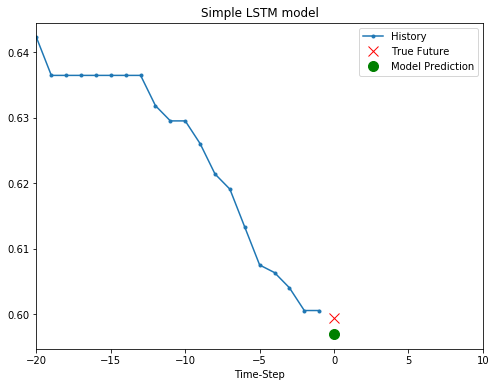

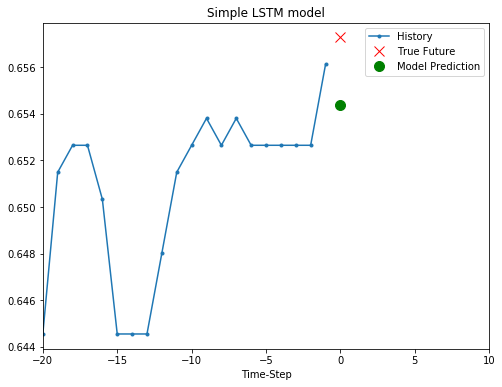

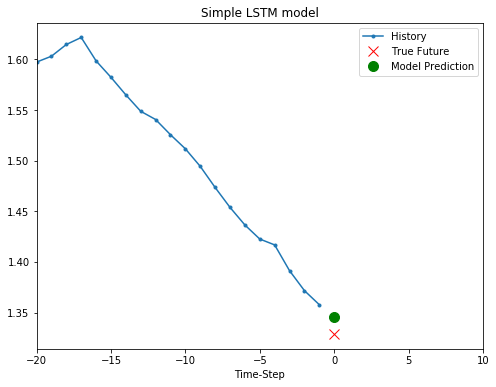

In [0]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()